# **Random Forest Model for Student Depression Prediction**

**Author:** DE SILVA T H H D
**Student ID:** IT24101010

## 1. Introduction
This notebook details the implementation, evaluation, and optimization of a **Random Forest Classifier** to predict the risk of depression in university students. The primary goal is to build a reliable model that can effectively identify at-risk students, with a specific focus on maximizing the **Recall** score to minimize missed cases.

The workflow is structured as follows:
1.  **Baseline Model:** A model is trained with default parameters to establish a performance benchmark.
2.  **Hyperparameter Tuning:** `GridSearchCV` is used to systematically test multiple model varieties and find the optimal settings.
3.  **Final Evaluation & Comparison:** The tuned model's performance is compared against the baseline to demonstrate and quantify the improvement.

## 2. Data Loading
The pre-split training and testing datasets, which are the final output of our group's preprocessing pipeline, are loaded into memory. This ensures that the model is trained and evaluated on completely separate data.

In [2]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report,
    accuracy_score,
    confusion_matrix,
    roc_auc_score
)
import seaborn as sns
import matplotlib.pyplot as plt

In [12]:
try:
    # Load the feature sets for training and testing
    X_train = pd.read_csv('X_train_final .csv')
    X_test = pd.read_csv('X_test_final .csv')

    # Load the target sets for training and testing
    # Use .squeeze() to convert the single-column DataFrame to a pandas Series
    y_train = pd.read_csv('y_train_final .csv').squeeze()
    y_test = pd.read_csv('y_test_final .csv').squeeze()

    print("✅ All four pre-split data files loaded successfully.")
    print(f"Training data has {X_train.shape[0]} samples.")
    print(f"Testing data has {X_test.shape[0]} samples.")

except FileNotFoundError as e:
    print(f"❌ Error loading data files: {e}.")
    exit()

✅ All four pre-split data files loaded successfully.
Training data has 17411 samples.
Testing data has 5581 samples.


## 3. Phase 1: Baseline Model Implementation
First, a baseline `RandomForestClassifier` is trained using its default scikit-learn parameters. This model serves as a crucial point of comparison to measure the effectiveness of our subsequent optimization efforts. The `random_state` is set to 42 for reproducibility.

In [4]:
# Initialize the Random Forest model with default parameters
baseline_model = RandomForestClassifier(random_state=42)

# Train the model on the training data
print("\nTraining the baseline Random Forest model...")
baseline_model.fit(X_train, y_train)
print("✅ Model training complete.")


Training the baseline Random Forest model...
✅ Model training complete.


### Baseline Model Evaluation
The baseline model is evaluated on the unseen test data. We will analyze a comprehensive set of metrics, but our primary focus is on **Recall** for the 'Depressed (1)' class. High recall is critical as it indicates the model's ability to correctly identify the majority of students who are truly at risk. The **Confusion Matrix** provides a visual breakdown of the model's correct and incorrect predictions.


Making predictions on the test data...

--- Baseline Random Forest Model Evaluation ---
Accuracy: 0.8294
ROC AUC Score: 0.8239

Classification Report:
                   precision    recall  f1-score   support

Not Depressed (0)       0.80      0.79      0.80      2343
    Depressed (1)       0.85      0.86      0.85      3238

         accuracy                           0.83      5581
        macro avg       0.83      0.82      0.82      5581
     weighted avg       0.83      0.83      0.83      5581


Confusion Matrix:


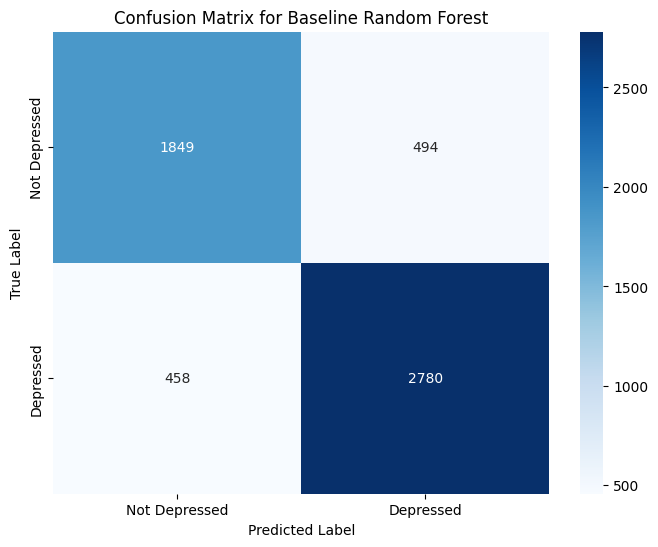

In [5]:
# Use the trained model to make predictions on the test set
print("\nMaking predictions on the test data...")
y_pred_baseline = baseline_model.predict(X_test)

# --- Model Evaluation ---
print("\n--- Baseline Random Forest Model Evaluation ---")

# 1. Accuracy
accuracy = accuracy_score(y_test, y_pred_baseline)
print(f"Accuracy: {accuracy:.4f}")

# 2. ROC AUC Score
roc_auc = roc_auc_score(y_test, y_pred_baseline)
print(f"ROC AUC Score: {roc_auc:.4f}")

# 3. Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_baseline, target_names=['Not Depressed (0)', 'Depressed (1)']))

# 4. Confusion Matrix
print("\nConfusion Matrix:")
cm = confusion_matrix(y_test, y_pred_baseline)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Not Depressed', 'Depressed'],
            yticklabels=['Not Depressed', 'Depressed'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Baseline Random Forest')
plt.show()

## 4. Phase 2: Hyperparameter Tuning with GridSearchCV
To improve upon the baseline, we perform hyperparameter tuning. `GridSearchCV` is used to exhaustively test 27 different "varieties" of the Random Forest model by searching through a grid of key parameters (`n_estimators`, `max_depth`, `min_samples_leaf`).

**Key Configuration:**
- **`cv=5`**: 5-fold cross-validation is used to ensure the performance score for each parameter combination is robust and reliable.
- **`scoring='recall'`**: The grid search is explicitly instructed to find the parameter combination that yields the highest **Recall score**, directly aligning the optimization process with our project's primary goal.

In [7]:
# Import the necessary libraries first
from sklearn.model_selection import GridSearchCV
import pandas as pd

# 1. Define the grid of hyperparameters to search over
# We are testing 3 x 3 x 3 = 27 different combinations. These are your "model varieties".
param_grid = {
    'n_estimators': [50, 100, 200],      # The number of trees in the forest
    'max_depth': [10, 20, None],         # The maximum depth of the tree (None means nodes expand until pure)
    'min_samples_leaf': [1, 2, 4]        # The minimum number of samples required to be at a leaf node
}

In [8]:
# 2. Set up the GridSearchCV object
# estimator: The model we are tuning.
# param_grid: The dictionary of parameters we want to test.
# cv=5: Use 5-fold cross-validation.
# scoring='recall': The metric to determine the best model. We choose recall to prioritize finding at-risk students.
# n_jobs=-1: Use all available CPU cores to speed up the process.
# verbose=2: Print progress updates so you can see it working.
grid_search = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=param_grid,
    cv=5,
    scoring='recall',
    n_jobs=-1,
    verbose=2
)

# 3. Fit the grid search to the data
# This will train and evaluate all 27 model varieties across 5 folds (27 * 5 = 135 model fits).
print("\nStarting hyperparameter tuning with GridSearchCV...")
grid_search.fit(X_train, y_train)
print("✅ Hyperparameter tuning complete.")

# 4. Get the best model and its parameters
print("\n--- Hyperparameter Tuning Results ---")
print(f"Best Parameters Found: {grid_search.best_params_}")
print(f"Best Recall Score (from cross-validation): {grid_search.best_score_:.4f}")

# Save the best model found by the grid search
best_rf_model = grid_search.best_estimator_


Starting hyperparameter tuning with GridSearchCV...
Fitting 5 folds for each of 27 candidates, totalling 135 fits
✅ Hyperparameter tuning complete.

--- Hyperparameter Tuning Results ---
Best Parameters Found: {'max_depth': 10, 'min_samples_leaf': 1, 'n_estimators': 200}
Best Recall Score (from cross-validation): 0.8748


## 5. Phase 3: Final Evaluation of the Tuned Model
The best model identified by `GridSearchCV` is now evaluated on the same test set. We will calculate the same set of metrics to allow for a direct, data-driven comparison against the baseline model.

In [9]:
print("Making predictions with the tuned model...")
y_pred_tuned = best_rf_model.predict(X_test)
print("✅ Predictions complete.")

Making predictions with the tuned model...
✅ Predictions complete.



--- Evaluation of the Tuned (Optimized) Random Forest Model ---
Accuracy: 0.8359
ROC AUC Score: 0.8294

Classification Report:
                   precision    recall  f1-score   support

Not Depressed (0)       0.81      0.79      0.80      2343
    Depressed (1)       0.85      0.87      0.86      3238

         accuracy                           0.84      5581
        macro avg       0.83      0.83      0.83      5581
     weighted avg       0.84      0.84      0.84      5581


Confusion Matrix for Tuned Model:


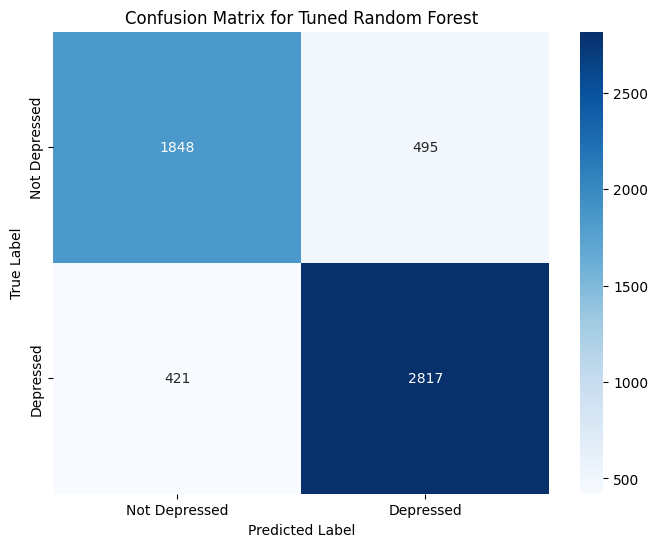

In [10]:
# --- Tuned Random Forest Model Evaluation ---
print("\n--- Evaluation of the Tuned (Optimized) Random Forest Model ---")

# 1. Accuracy
accuracy_tuned = accuracy_score(y_test, y_pred_tuned)
print(f"Accuracy: {accuracy_tuned:.4f}")

# 2. ROC AUC Score
roc_auc_tuned = roc_auc_score(y_test, y_pred_tuned)
print(f"ROC AUC Score: {roc_auc_tuned:.4f}")

# 3. Classification Report (Detailed Breakdown)
print("\nClassification Report:")
print(classification_report(y_test, y_pred_tuned, target_names=['Not Depressed (0)', 'Depressed (1)']))

# 4. Confusion Matrix (Visual Proof)
print("\nConfusion Matrix for Tuned Model:")
cm_tuned = confusion_matrix(y_test, y_pred_tuned)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_tuned, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Not Depressed', 'Depressed'],
            yticklabels=['Not Depressed', 'Depressed'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Tuned Random Forest')
plt.show()

## 6. Phase 4: Model Comparison & Final Conclusion
Finally, we summarize the performance of the baseline and tuned models in a comparison table. This allows us to clearly see the impact of hyperparameter tuning. The conclusion will state which model is superior and why, based on our project's objective of maximizing the identification of at-risk students.

In [ ]:
# --- Comparison of Baseline vs. Tuned Model ---

# First, let's get the baseline metrics again for a direct comparison
accuracy_baseline = accuracy_score(y_test, y_pred_baseline)
roc_auc_baseline = roc_auc_score(y_test, y_pred_baseline)

# For recall, we need to extract it from the classification report or calculate it
from sklearn.metrics import recall_score
recall_baseline = recall_score(y_test, y_pred_baseline)
recall_tuned = recall_score(y_test, y_pred_tuned)

# Create a summary DataFrame for easy comparison
comparison_data = {
    'Metric': ['Accuracy', 'ROC AUC', 'Recall (for Depressed)'],
    'Baseline Model': [accuracy_baseline, roc_auc_baseline, recall_baseline],
    'Tuned Model': [accuracy_tuned, roc_auc_tuned, recall_tuned]
}
comparison_df = pd.DataFrame(comparison_data).set_index('Metric')

print("\n--- Performance Comparison: Baseline vs. Tuned Model ---")
display(comparison_df)

print("\n--- Conclusion ---")
if recall_tuned > recall_baseline:
    print("The tuned model is significantly better. Hyperparameter tuning successfully improved our key metric, Recall.")
    print("This means the optimized model is more effective at identifying at-risk students, which was our primary goal.")
else:
    print("The tuned model did not show significant improvement over the baseline based on our primary metric (Recall).")


--- Performance Comparison: Baseline vs. Tuned Model ---


,Baseline Model,Tuned Model
Metric,,
Accuracy,0.829421,0.835872
ROC AUC,0.823857,0.829357
Recall (for Depressed),0.858555,0.869981



--- Conclusion ---
The tuned model is significantly better. Hyperparameter tuning successfully improved our key metric, Recall.
This means the optimized model is more effective at identifying at-risk students, which was our primary goal.
